# \begin{equation*} \frac{D \sigma}{D t} = \dot\sigma_{\theta} = \frac{\partial \sigma_{\theta}}{\partial \theta} \dot\theta + \frac{\partial \sigma_{\theta}}{\partial S} \dot S \end{equation*}
## **SOSE**

In [2]:
from dask_gateway import Gateway

g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

In [3]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.c95664fcf69d4a73a8a6170fb4e88ed2/status,


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import fsspec
from fastjmd95 import jmd95numba
import fastjmd95
import dask.array as dsa
import json

In [3]:
#bringing in uploaded ds

with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

def open_ds(filename):
    path = "pangeo-tmp/stb2145/models/SOSE/"
    return xr.open_zarr(gcfs_w_token.get_mapper(path + filename), consolidated=False)

ds_slt = open_ds('budget_slt.zarr')
ds_temp = open_ds('budget_th.zarr')
coords_unrolled = open_ds('coords.zarr')
ds_tns = open_ds('ds_tns.zarr')
ds_vel = open_ds('ds_vel.zarr')
ds_empmr = open_ds('ds_SIempmr.zarr')

ds_unrolled = xr.merge([ds_tns, ds_slt, ds_temp, ds_vel, ds_empmr])

In [4]:
#WG boundaries (65˚W, 30˚E; 80˚S, 57˚S)
#WG model's boundaries (-77.87497˚S, -57.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0 #-77.87497
upper_lat = 125 #-57.041634
left_lon =  310 #51.75
right_lon = 880 #146.75

#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))
lat_range_u = dict(YG=slice(lower_lat, upper_lat+1))
lon_range_u = dict(XG=slice(left_lon, right_lon+1))

coords = coords_unrolled.roll(XC=700, XG=700, roll_coords=True).isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)
ds = ds_unrolled.roll(XC=700, XG=700, roll_coords=True).isel(**lat_range, **lon_range, **lat_range_u, **lon_range_u)

In [5]:
pref = 2000

# <font color='Green'> \begin{equation*} Temperature \end{equation*} </font>

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial \theta}\end{equation*} </font>

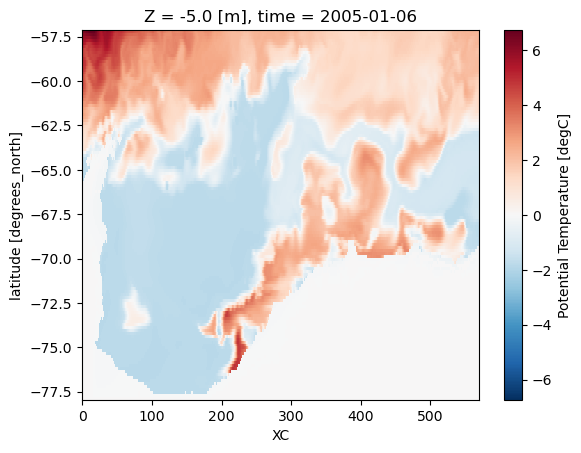

In [11]:
ds.THETA[0,0].drop('XC').plot()

### 5. **`dsa.map_blocks()`-`fastjmd95`-model data**
Runtime:

In [35]:
drhodt_wg = dsa.map_blocks(jmd95numba.drhodt, 
                            ds_wg.SALT.data, 
                            ds_wg.THETA.data, pref,
                            dtype=ds_wg.THETA.dtype)#.load()
drhodt_wg

,Array,Chunk
Bytes,3.98 GB,9.10 MB
Shape,"(438, 42, 95, 570)","(1, 42, 95, 570)"
Count,6572 Tasks,438 Chunks
Type,float32,numpy.ndarray


In [61]:
drhodt = dsa.map_blocks(jmd95numba.drhodt, 
                        ds.SALT.data, 
                        ds.THETA.data, pref,
                        dtype=ds.THETA.dtype)#.load()
drhodt

,Array,Chunk
Bytes,50.86 GB,116.12 MB
Shape,"(438, 42, 320, 2160)","(1, 42, 320, 2160)"
Count,5696 Tasks,438 Chunks
Type,float32,numpy.ndarray


In [59]:
type(drhodt)

dask.array.core.Array

In [66]:
%time drhodt_wg.mean(axis=(0, 1,)).compute()

CPU times: user 1.05 s, sys: 33.8 ms, total: 1.09 s
Wall time: 33.3 s


array([[-0.00478695, -0.00478695, -0.00478695, ..., -0.00478695,
        -0.00478695, -0.00478695],
       [-0.00478695, -0.00478695, -0.00478695, ..., -0.00478695,
        -0.00478695, -0.00478695],
       [-0.00478695, -0.00478695, -0.00478695, ..., -0.00478695,
        -0.00478695, -0.00478695],
       ...,
       [-0.1004128 , -0.10041294, -0.10036682, ..., -0.10846028,
        -0.10850379, -0.10853367],
       [-0.10357573, -0.1009112 , -0.09555993, ..., -0.10834187,
        -0.10838421, -0.1084111 ],
       [-0.09877244, -0.09607681, -0.09334263, ..., -0.10827856,
        -0.10831393, -0.10833538]], dtype=float32)

In [68]:
%time drhodt.mean(axis=(0, 1,)).compute()

CPU times: user 949 ms, sys: 50.8 ms, total: 999 ms
Wall time: 54.7 s


array([[-0.00478695, -0.00478695, -0.00478695, ..., -0.00478695,
        -0.00478695, -0.00478695],
       [-0.00478695, -0.00478695, -0.00478695, ..., -0.00478695,
        -0.00478695, -0.00478695],
       [-0.00478695, -0.00478695, -0.00478695, ..., -0.00478695,
        -0.00478695, -0.00478695],
       ...,
       [-0.16931999, -0.16931838, -0.16931146, ..., -0.17225058,
        -0.17226288, -0.17227   ],
       [-0.1693209 , -0.16932145, -0.16931662, ..., -0.17224328,
        -0.17225844, -0.17226723],
       [-0.16909692, -0.16909528, -0.16908666, ..., -0.17204258,
        -0.17204542, -0.17205133]], dtype=float32)

In [72]:
drhodt_wg.compute()

CommClosedError: in <closed TLS>: Stream is closed

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/p

In [44]:
drhodt_xr = xr.Dataset({'drhodt' : (['time', 'Z','YC','XC'], drhodt)})

In [123]:
(-drhodt[0,0]).plot()

AttributeError: 'Array' object has no attribute 'plot'

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial \theta} \dot \theta \end{equation*} </font>

In [36]:
ds_tmp_wg = ds_tmp_rolled.isel(**lat_range_noface, **lon_range_noface)

In [37]:
ds_tmp_wg

<xarray.Dataset>
Dimensions:                  (XC: 570, YC: 95, Z: 42, time: 438)
Coordinates:
  * XC                       (XC) float32 295.08334 295.25 ... 29.75 29.916668
  * YC                       (YC) float32 -77.87497 -77.7083 ... -62.2083
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    sw_flux_conv_TH          (time, YC, XC, Z) float32 dask.array<chunksize=(1, 95, 570, 42), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

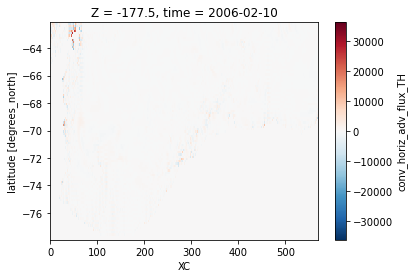

In [137]:
ds_wg.conv_horiz_adv_flux_TH[80,10].drop('XC').plot()

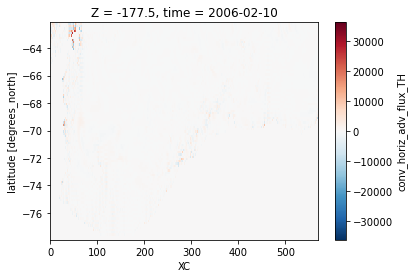

In [139]:
ds_tmp_wg.conv_horiz_adv_flux_TH[80,10].drop('XC').plot()

In [140]:
drhodt_wg.shape

(438, 42, 95, 570)

In [61]:
ds_tmp_wg['sw_flux_conv_TH'] = ds_tmp_wg.sw_flux_conv_TH.transpose('time', 'Z', 'YC', 'XC')

In [62]:
ds_tmp_wg#.sw_flux_conv_TH

<xarray.Dataset>
Dimensions:                  (XC: 570, YC: 95, Z: 42, time: 438)
Coordinates:
  * XC                       (XC) float32 295.08334 295.25 ... 29.75 29.916668
  * YC                       (YC) float32 -77.87497 -77.7083 ... -62.2083
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    sw_flux_conv_TH          (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

In [40]:
ds_sig_theta = (drhodt_wg * ds_tmp_wg)#.chunk({'XC':-1, 'YC':-1, 'Z':-1, 'time':1})

In [41]:
ds_sig_theta

<xarray.Dataset>
Dimensions:                  (XC: 570, YC: 95, Z: 42, time: 438)
Coordinates:
  * XC                       (XC) float32 295.08334 295.25 ... 29.75 29.916668
  * YC                       (YC) float32 -77.87497 -77.7083 ... -62.2083
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    sw_flux_conv_TH          (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

In [145]:
rhs_theta = (ds_sig_theta.conv_horiz_adv_flux_TH + 
              ds_sig_theta.conv_horiz_diff_flux_TH + 
              ds_sig_theta.conv_vert_adv_flux_TH +
              ds_sig_theta.conv_vert_diff_flux_TH + 
              ds_sig_theta.surface_flux_conv_TH + 
              ds_sig_theta.sw_flux_conv_TH)#.load()

lhs_theta = ds_sig_theta.total_tendency_TH_truth#.load()

## **Why does it plot an output but I can't run `drhodt_wg.compute()` without it crashing?**

In [147]:
client.restart()

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.18b3e7a7890048f3b8b8acd90ff469af Dashboard: /services/dask-gateway/clusters/prod.18b3e7a7890048f3b8b8acd90ff469af/status,Cluster Workers: 30 Cores: 60 Memory: 257.70 GB


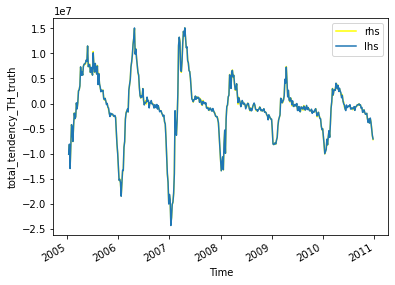

In [148]:
#checking equality
rhs_theta[1:-1].sum(['XC', 'YC', 'Z']).plot(label='rhs', color='yellow')
lhs_theta[1:-1].sum(['XC', 'YC', 'Z']).plot(label='lhs')
plt.legend();

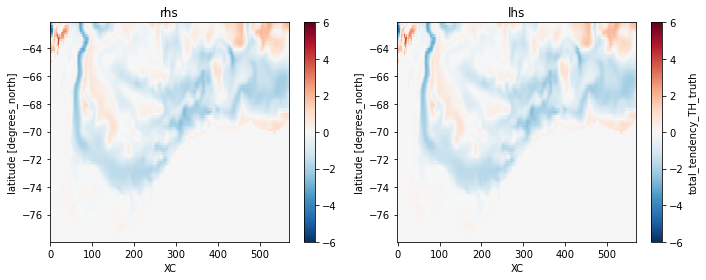

In [150]:
#checking equality
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
rhs_theta[1:-1].mean(dim=['time', 'Z']).drop('XC').plot(ax=ax0, vmax=6)
ax0.set_title('rhs')
lhs_theta[1:-1].mean(dim=['time', 'Z']).drop('XC').plot(ax=ax1, vmax=6)
ax1.set_title('lhs')
plt.tight_layout();

In [151]:
rhs_vars = [dvar for dvar in ds_sig_theta.data_vars
            if dvar != 'total_tendency_TH_truth']
total_tendency_check = sum([ds_sig_theta[dvar] for dvar in rhs_vars])
total_tendency_check

<xarray.DataArray (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<add, shape=(438, 42, 95, 570), dtype=float32, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

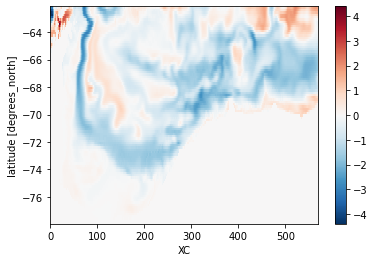

In [153]:
total_tendency_check.mean(dim=['time', 'Z']).drop('XC').plot()

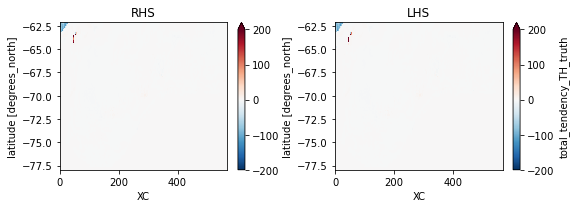

In [152]:
#checking equality
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[200, 0].drop('XC').plot(ax=ax0, robust=True, vmax=200)
ax0.set_title('RHS')

ds_sig_theta.total_tendency_TH_truth[200, 0].drop('XC').plot(ax=ax1, robust=True, vmax=200)
ax1.set_title('LHS')
plt.tight_layout();

In [154]:
ds_sig_theta

<xarray.Dataset>
Dimensions:                  (XC: 570, YC: 95, Z: 42, time: 438)
Coordinates:
  * XC                       (XC) float32 295.08334 295.25 ... 29.75 29.916668
  * YC                       (YC) float32 -77.87497 -77.7083 ... -62.2083
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    sw_flux_conv_TH          (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

# <font color='Green'> \begin{equation*} Salinity \end{equation*} </font>

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial S} \end{equation*} </font>

In [20]:
drhods_wg = dsa.map_blocks(jmd95numba.drhods, 
                            ds_wg.SALT.data, 
                            ds_wg.THETA.data, pref,
                            dtype=ds_wg.SALT.dtype)#.load()
drhods_wg

,Array,Chunk
Bytes,3.98 GB,9.10 MB
Shape,"(438, 42, 95, 570)","(1, 42, 95, 570)"
Count,6572 Tasks,438 Chunks
Type,float32,numpy.ndarray


In [21]:
drhods_wg[0,0]#.plot()

dask.array<getitem, shape=(95, 570), dtype=float32, chunksize=(95, 570), chunktype=numpy.ndarray>

## <font color='Green'> \begin{equation*} \frac{\partial \rho}{\partial S} \dot S \end{equation*} </font>

In [22]:
ds_slt_wg = ds_slt_rolled.isel(**lat_range_noface, **lon_range_noface)

In [23]:
ds_slt_wg

<xarray.Dataset>
Dimensions:                   (XC: 570, YC: 95, Z: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 295.08334 295.25 ... 29.75 29.916668
  * YC                        (YC) float32 -77.87497 -77.7083 ... -62.2083
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

In [24]:
drhods_wg.shape

(438, 42, 95, 570)

In [25]:
ds_slt_wg.conv_horiz_adv_flux_SLT.shape

(438, 42, 95, 570)

In [26]:
ds_sig_salt = drhods_wg * ds_slt_wg

In [27]:
ds_sig_salt

<xarray.Dataset>
Dimensions:                   (XC: 570, YC: 95, Z: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 295.08334 295.25 ... 29.75 29.916668
  * YC                        (YC) float32 -77.87497 -77.7083 ... -62.2083
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

In [28]:
rhs_salt = (ds_sig_salt.conv_horiz_adv_flux_SLT + 
            ds_sig_salt.conv_horiz_diff_flux_SLT + 
            ds_sig_salt.conv_vert_adv_flux_SLT +
            ds_sig_salt.conv_vert_diff_flux_SLT + 
            ds_sig_salt.surface_flux_conv_SLT +
            ds_sig_salt.lin_fs_correction_SLT)#.load()

lhs_salt = ds_sig_salt.total_tendency_SLT_truth#.load()

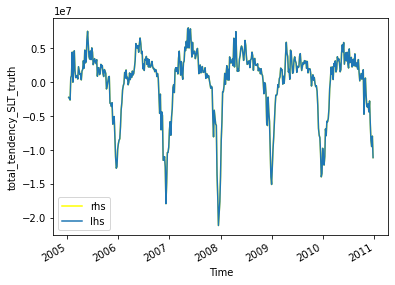

In [34]:
#checking equality
rhs_salt[1:-1].sum(['XC', 'YC', 'Z']).plot(label='rhs', color='yellow')
lhs_salt[1:-1].sum(['XC', 'YC', 'Z']).plot(label='lhs')
plt.legend();

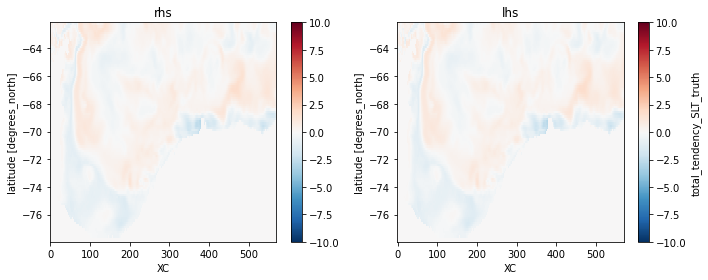

In [30]:
#checking equality
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
rhs_salt[1:-1].mean(dim=['time', 'Z']).drop('XC').plot(ax=ax0, vmax=10)
ax0.set_title('rhs')
lhs_salt[1:-1].mean(dim=['time', 'Z']).drop('XC').plot(ax=ax1, vmax=10)
ax1.set_title('lhs')
plt.tight_layout();

In [31]:
%time drhods_wg.mean(axis=(0, 1,)).compute()

CPU times: user 814 ms, sys: 79.8 ms, total: 894 ms
Wall time: 40.4 s


array([[0.80592716, 0.80592716, 0.80592716, ..., 0.80592716, 0.80592716,
        0.80592716],
       [0.80592716, 0.80592716, 0.80592716, ..., 0.80592716, 0.80592716,
        0.80592716],
       [0.80592716, 0.80592716, 0.80592716, ..., 0.80592716, 0.80592716,
        0.80592716],
       ...,
       [0.7909463 , 0.7909478 , 0.79096067, ..., 0.790559  , 0.790549  ,
        0.7905423 ],
       [0.7904215 , 0.7908213 , 0.79162514, ..., 0.79058546, 0.7905756 ,
        0.7905696 ],
       [0.7910855 , 0.79149264, 0.79190946, ..., 0.79059935, 0.7905912 ,
        0.7905863 ]], dtype=float32)

In [32]:
rhs_vars_salt = [dvar for dvar in ds_sig_salt.data_vars
            if dvar != 'total_tendency_SLT_truth']
total_tendency_check_salt = sum([ds_sig_salt[dvar] for dvar in rhs_vars_salt])
total_tendency_check_salt

<xarray.DataArray (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<add, shape=(438, 42, 95, 570), dtype=float32, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

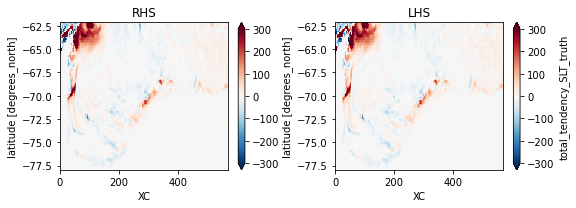

In [33]:
#checking equality
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check_salt[200, 0].drop('XC').plot(ax=ax0, robust=True, vmax=300)
ax0.set_title('RHS')

ds_sig_salt.total_tendency_SLT_truth[200, 0].drop('XC').plot(ax=ax1, robust=True, vmax=300)
ax1.set_title('LHS')
plt.tight_layout();

## Saving Data

In [50]:
drhodts = xr.Dataset({'drhodt_wg':(['time', 'Z', 'YC', 'XC'], drhodt_wg), 
                      'drhods_wg':(['time', 'Z', 'YC', 'XC'], drhods_wg)}, 
                     coords=dict(time=ds_tmp_wg.time, Z=ds_tmp_wg.Z, YC=ds_tmp_wg.YC, XC=ds_tmp_wg.XC))

In [52]:
drhodts

<xarray.Dataset>
Dimensions:    (XC: 570, YC: 95, Z: 42, time: 438)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * Z          (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * YC         (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
  * XC         (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
Data variables:
    drhodt_wg  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    drhods_wg  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

In [63]:
ds_tmp_slt_wg = xr.merge([ds_tmp_wg, ds_slt_wg])

In [64]:
ds_tmp_slt_wg

<xarray.Dataset>
Dimensions:                   (XC: 570, YC: 95, Z: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 295.08334 295.25 ... 29.75 29.916668
  * YC                        (YC) float32 -77.87497 -77.7083 ... -62.2083
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_TH      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_TH      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    sw_flux_conv_TH           (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_TH_truth   (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

In [12]:
import json
with open('/home/jovyan/WMT-project/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [57]:
#saving theta component of drho/dtheta
gcsmap_sig_theta = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/ds_sig_theta_wg.zarr')
ds_sig_theta.to_zarr(gcsmap_sig_theta, mode='w')

In [65]:
#saving salt component of drho/dsalt
gcsmap_sig_salt = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/ds_sig_salt_wg.zarr')
ds_sig_salt.to_zarr(gcsmap_sig_salt, mode='w')

In [66]:
drhodts

<xarray.Dataset>
Dimensions:    (XC: 570, YC: 95, Z: 42, time: 438)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * Z          (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * YC         (YC) float32 -77.87497 -77.7083 -77.54163 ... -62.374966 -62.2083
  * XC         (XC) float32 295.08334 295.25 295.4167 ... 29.75 29.916668
Data variables:
    drhodt_wg  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    drhods_wg  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

In [67]:
#saving rhodt and drhods
gcsmap_drhodts = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/drhodts_wg.zarr')
drhodts.to_zarr(gcsmap_drhodts, mode='w')

In [69]:
ds_tmp_slt_wg

<xarray.Dataset>
Dimensions:                   (XC: 570, YC: 95, Z: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 295.08334 295.25 ... 29.75 29.916668
  * YC                        (YC) float32 -77.87497 -77.7083 ... -62.2083
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_TH      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_TH      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    sw_flux_conv_TH           (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_TH_truth   (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

In [70]:
#saving rolled ds_tmp_wg and ds_slt_wg
gcsmap_ds_tmp_slt_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/ds_tmp_slt_wg.zarr')
ds_tmp_slt_wg.to_zarr(gcsmap_ds_tmp_slt_wg, mode='w')

In [13]:
#saving rolled coords_wg
gcsmap_coords_wg = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/coords_wg.zarr')
coords_wg.to_zarr(gcsmap_coords_wg, mode='w')